In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import time, datetime
from scipy.special import erf
from astropy.table import Table, vstack

%matplotlib inline

# Everything above should import with no issue, everything below needs directing
homepath = "/global/homes/c/cpopik/"
packpath = homepath+"Packages/"
resultspath = homepath+"Results/NaWrapper/"

import camb
sys.path.append(packpath + "hmvec/")
import hmvec as hm

In [2]:
date0 = '2023-08-09'
lrgsXlrgs_ = np.load(resultspath+"LRGs*LRGs/Data/"+date0+"_results.npy")

date1 = '2023-08-09'
lrgsXlrgs_covmat_ = np.load(resultspath+"LRGs*LRGs/Data/AnalyticalErrors/"+date1+"_results.npy")
lrgsXlrgs_analerr_ = np.sqrt(np.diag(lrgsXlrgs_covmat_))

In [3]:
lb, rb = 11, 27
xdata = lrgsXlrgs_[0]
ydata = lrgsXlrgs_[1]
yerr = lrgsXlrgs_analerr_


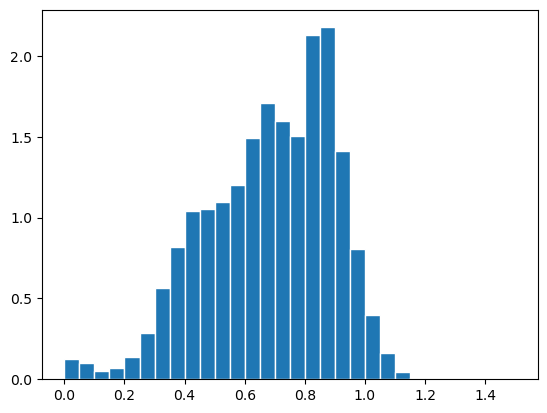

In [4]:
# Get z distribution for the Cls calculation

table = Table.read(homepath + '/DESI_Data/DESI_LRGs_ACTD56.csv')
targetdata = table.to_pandas()

# Sets RA limits to match ACT maps
targetdata['RA'].where(targetdata['RA'] < 180, targetdata['RA'] - 360, inplace=True)


data_zs = targetdata['Z_PHOT_MEAN'].values
area = (max(targetdata.RA)-min(targetdata.RA))*(max(targetdata.DEC)-min(targetdata.DEC))

try: bins = np.arange(zlow, zhigh+0.05, 0.05)
except NameError: bins = np.arange(0, 1.5+0.05, 0.05)+np.array([1e-4]+[0]*30)

gdndz, zbins = plt.hist(data_zs, bins=bins, ec='w', weights=np.ones(len(data_zs))/area, density=True)[0:2]
gzs = zbins[:-1]+((zbins[1]-zbins[0])/2)

Text(0.5, 1.0, '(photo) Redshift Distribution of DESI LRGs')

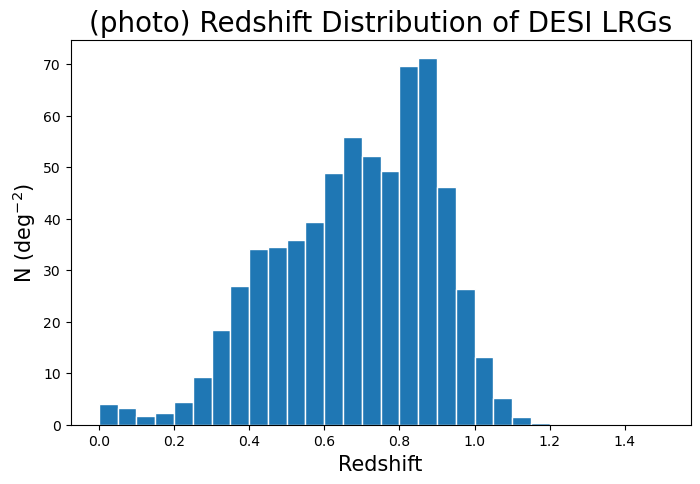

In [26]:
plt.figure(figsize=(8, 5), dpi=100)
aasdas, asdas = plt.hist(data_zs, bins=bins, ec='w', weights=np.ones(len(data_zs))/area)[0:2]
plt.ylabel('N (deg$^{-2}$)', fontsize=15), plt.xlabel('Redshift', fontsize=15)
plt.title('(photo) Redshift Distribution of DESI LRGs', fontsize=20)

In [5]:
# Make the halo model

try: zs = np.arange(zlow, zhigh+0.05, 0.05)
except NameError: zs = np.arange(0, 1.5+0.05, 0.05)+np.array([1e-4]+[0]*30)
zs = zs[0:-1]

ms = np.geomspace(10**11.75, 10**15, 25)  # Changes MCMC time
ks = np.geomspace(1e-4, 100, 1001)
hcos = hm.HaloModel(zs,ks,ms=ms)

xmax = 20
nxs = 50  # changes MCMC Time

hcos.add_battaglia_pres_profile("y",family='pres', xmax=xmax,nxs=nxs, ignore_existing=True)

mthresh=10**10.5+np.zeros(hcos.zs.size)

/global/homes/c/cpopik/Packages/hmvec/hmvec/fft.py:90: RuntimeWarning: invalid value encountered in divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


In [6]:
# Add the HOD and pressure profiles

def Nc_LRG(logM, params):
    f_ic, logM_cut, sigma = [params.get(key) for key in ['f_ic', 'logM_cut', 'sigma']]
    return (f_ic / 2) * (1- erf((logM_cut - logM)/(np.sqrt(2)*sigma)))

def Ns_LRG(logM, Nc, params):
    kappa, logM_cut, logM_1, alpha = [params.get(key) for key in ['kappa', 'logM_cut', 'logM_1', 'alpha']]
    M, M_cut, M_1 = 10**logM, 10**logM_cut, 10**logM_1
    diffstep = (M - kappa * M_cut)
    diffstep[diffstep < 0] = 0
    return (diffstep / M_1)**alpha * Nc

In [7]:
params = {
        'logM_cut': np.array([11])[..., None]*np.ones(hcos.ms.size),
        'logM_1': np.array([12]),
        'sigma': np.array([0.25]),
        'alpha': np.array([1.2]),
        'kappa': np.array([0.6]),
        'f_ic': np.array([0.9])
        }

mthresh=10**10.5+np.zeros(hcos.zs.size)
hcos.add_custom_hod(name = "LRG_HOD", ignore_existing=True, 
                    Nc_model = Nc_LRG, Ns_model = Ns_LRG, 
                    model_params=params, z_dep=False)
    
Pgg = hcos.get_power('LRG_HOD', verbose=False);
C_gg = hcos.C_gg_new(xdata, zs, ks, Pgg, gzs=gzs, gdndz=gdndz)

In [11]:
hcos.h_of_z(0)*(3e5)

67.34659082050689

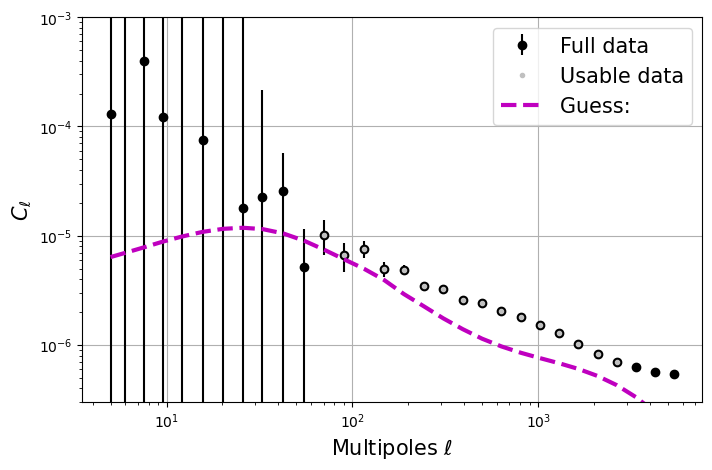

In [8]:
plt.figure(figsize=(8, 5))
plt.xlabel('Multipoles $\\ell$', fontsize=15), plt.xscale('log')
plt.ylabel('$C_{\\ell}$', fontsize=15), plt.yscale('log')

plt.errorbar(xdata, ydata, yerr=yerr, ls='', marker='o', c='k', label='Full data')
plt.errorbar(xdata[lb:rb], ydata[lb:rb], ls='', marker='.', c='silver', label='Usable data')

plt.errorbar(xdata, C_gg, c='m', lw=3, ls='--', label='Guess: ')


plt.grid(True), plt.legend(fontsize=15), plt.ylim(3e-7, 1e-3)
plt.show()

In [9]:
hcosngal = hcos.get_ngal(hcos.hods['LRG_HOD']['Nc'], hcos.hods['LRG_HOD']['Ns'])

In [10]:
hcos.add_custom_hod(name = "LRG_HOD2", ngal=hcosngal, ignore_existing=True, 
                    Nc_model = Nc_LRG, Ns_model = Ns_LRG, 
                    model_params=params, z_dep=False)
    
Pgg2 = hcos.get_power('LRG_HOD2', verbose=False);
C_gg2 = hcos.C_gg_new(xdata, zs, ks, Pgg2, gzs=gzs, gdndz=gdndz)

In [11]:
C_gg-C_gg2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

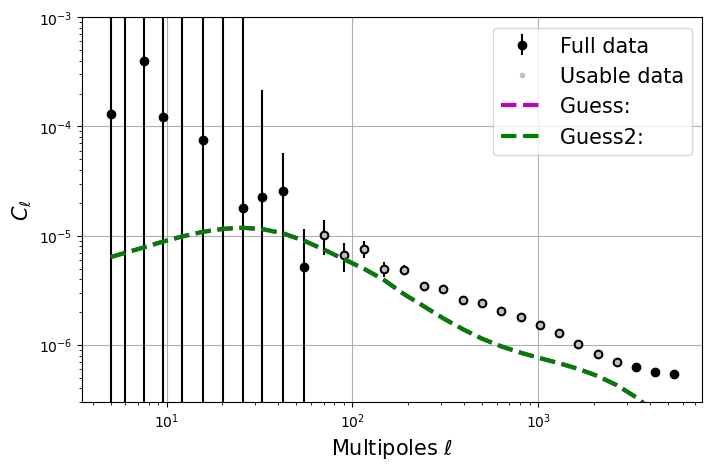

In [12]:
plt.figure(figsize=(8, 5))
plt.xlabel('Multipoles $\\ell$', fontsize=15), plt.xscale('log')
plt.ylabel('$C_{\\ell}$', fontsize=15), plt.yscale('log')

plt.errorbar(xdata, ydata, yerr=yerr, ls='', marker='o', c='k', label='Full data')
plt.errorbar(xdata[lb:rb], ydata[lb:rb], ls='', marker='.', c='silver', label='Usable data')

plt.errorbar(xdata, C_gg, c='m', lw=3, ls='--', label='Guess: ')
plt.errorbar(xdata, C_gg2, c='g', lw=3, ls='--', label='Guess2: ')


plt.grid(True), plt.legend(fontsize=15), plt.ylim(3e-7, 1e-3)
plt.show()

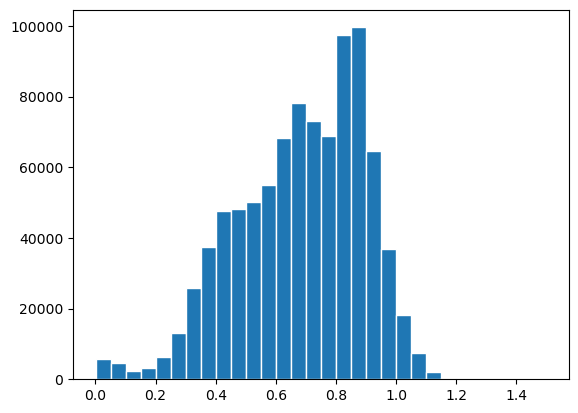

In [87]:
gdndz_test, zbins_test = plt.hist(data_zs, bins=bins, ec='w')[0:2]

In [53]:
(hcos.h_of_z(hcos.zs)/0.7)**3

array([3.29875669e-11, 3.54596753e-11, 3.82521399e-11, 4.13903082e-11,
       4.49064194e-11, 4.88350240e-11, 5.32130543e-11, 5.80798878e-11,
       6.34774071e-11, 6.94500533e-11, 7.60448775e-11, 8.33115879e-11,
       9.13025946e-11, 1.00073053e-10, 1.09680903e-10, 1.20186913e-10,
       1.31654712e-10, 1.44150834e-10, 1.57744749e-10, 1.72508902e-10,
       1.88518751e-10, 2.05852797e-10, 2.24592624e-10, 2.44822932e-10,
       2.66631568e-10, 2.90109567e-10, 3.15351179e-10, 3.42453909e-10,
       3.71518544e-10, 4.02649192e-10])

In [44]:
gdndz_test.

30

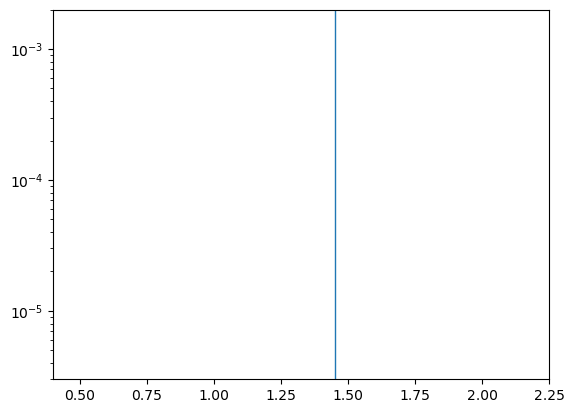

In [65]:
plt.yscale('log'), plt.xlim(0.4, 2.25), plt.ylim(3e-6, 2e-3)
plt.stairs(gdndz_test*(hcos.h_of_z(hcos.zs)/0.7)**3/(834/41253), zbins_test)

In [14]:
Cl_shotnoise = (4*np.pi*834/41253)/326509

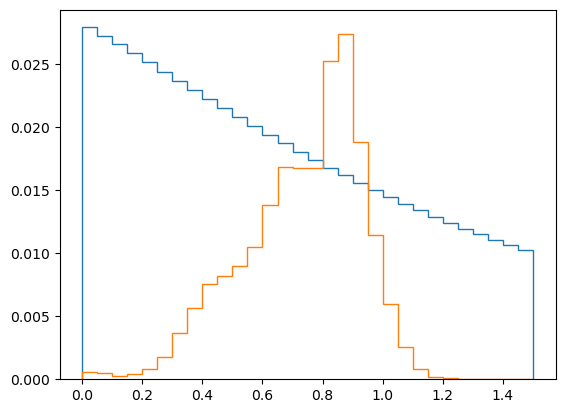

In [89]:
Cl_shotnoise = (4*np.pi*834/41253)/326509
ngal_test = gdndz_test*Cl_shotnoise

plt.stairs(hcosngal, bins)
plt.stairs(gdndz_test*(hcos.h_of_z(hcos.zs)/0.7)**2, zbins_test)

In [78]:
(hcos.h_of_z(hcos.zs)/0.7)**2

array([1.02856922e-07, 1.07933560e-07, 1.13528219e-07, 1.19655438e-07,
       1.26339441e-07, 1.33604454e-07, 1.41474703e-07, 1.49974416e-07,
       1.59127822e-07, 1.68959152e-07, 1.79492639e-07, 1.90752516e-07,
       2.02763018e-07, 2.15548381e-07, 2.29132844e-07, 2.43540646e-07,
       2.58796028e-07, 2.74923231e-07, 2.91946500e-07, 3.09890080e-07,
       3.28778217e-07, 3.48635158e-07, 3.69485154e-07, 3.91352455e-07,
       4.14261314e-07, 4.38235983e-07, 4.63300718e-07, 4.89479775e-07,
       5.16797413e-07, 5.45277890e-07])

In [77]:
(834/41253)

0.020216711511890046

In [25]:
hcos.hods["LRG_HOD3"]['Nc'][0, :]

array([0.89878509, 0.89982108, 0.89998002, 0.89999831, 0.89999989,
       0.89999999, 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ,
       0.9       , 0.9       , 0.9       , 0.9       , 0.9       ])

In [20]:
hcos.add_custom_hod(name = "LRG_HOD3", ngal=ngal_test*2, ignore_existing=True, 
                    Nc_model = Nc_LRG, Ns_model = Ns_LRG, 
                    model_params=params, z_dep=False)
    
Pgg3 = hcos.get_power('LRG_HOD3', verbose=False);
C_gg3 = hcos.C_gg_new(xdata, zs, ks, Pgg3, gzs=gzs, gdndz=gdndz)

In [20]:
C_gg3-C_gg

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

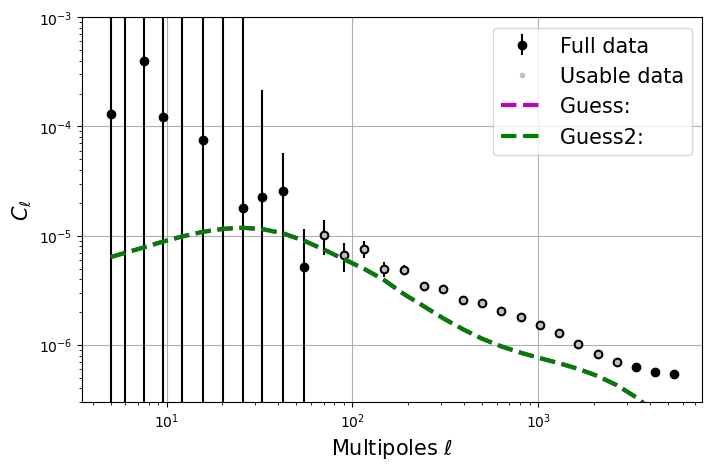

In [44]:
plt.figure(figsize=(8, 5))
plt.xlabel('Multipoles $\\ell$', fontsize=15), plt.xscale('log')
plt.ylabel('$C_{\\ell}$', fontsize=15), plt.yscale('log')

plt.errorbar(xdata, ydata, yerr=yerr, ls='', marker='o', c='k', label='Full data')
plt.errorbar(xdata[lb:rb], ydata[lb:rb], ls='', marker='.', c='silver', label='Usable data')

plt.errorbar(xdata, C_gg, c='m', lw=3, ls='--', label='Guess: ')
plt.errorbar(xdata, C_gg2, c='g', lw=3, ls='--', label='Guess2: ')


plt.grid(True), plt.legend(fontsize=15), plt.ylim(3e-7, 1e-3)
plt.show()

In [39]:
hcos.add_custom_hod(name = "LRG_HOD", ngal=hcosngal, ignore_existing=True, 
                    Nc_model = Nc_LRG, Ns_model = Ns_LRG, 
                    model_params=params, z_dep=False)

KeyboardInterrupt: 

In [50]:
from hmvec import tinker,utils

hod_params = ['hod_sig_log_mstellar','hod_bisection_search_min_log10mthresh',
           'hod_bisection_search_max_log10mthresh','hod_bisection_search_rtol',
           'hod_bisection_search_warn_iter','hod_alphasat','hod_Bsat',
              'hod_betasat','hod_Bcut','hod_betacut','hod_A_log10mthresh']
# Set default parameters
pparams = {}
for ip in hod_params:
    pparams[ip] = hcos.p[ip]

ngal = hcosngal
mthresh=None

if ngal is not None:
    try: assert ngal.size == hcos.zs.size
    except:
        raise ValueError("ngal has to be a vector of size self.zs")
    assert mthresh is None

    try:
        Msat_override = pparams['hod_Msat_override']
    except:
        Msat_override = None
    try:
        Mcut_override = pparams['hod_Mcut_override']
    except:
        Mcut_override = None

    nfunc = lambda ilog10mthresh: hm.ngal_from_mthresh(ilog10mthresh,
                                                    hcos.zs,
                                                    hcos.nzm,
                                                    hcos.ms,
                                                    sig_log_mstellar=pparams['hod_sig_log_mstellar'],
                                                    alphasat=pparams['hod_alphasat'],
                                                    Bsat=pparams['hod_Bsat'],betasat=pparams['hod_betasat'],
                                                    Bcut=pparams['hod_Bcut'],betacut=pparams['hod_betacut'],
                                                    Msat_override=Msat_override,
                                                    Mcut_override=Mcut_override)

    log10mthresh = utils.vectorized_bisection_search(ngal,nfunc,
                                                     [pparams['hod_bisection_search_min_log10mthresh'],
                                                      pparams['hod_bisection_search_max_log10mthresh']],
                                                     "decreasing",
                                                     rtol=pparams['hod_bisection_search_rtol'],
                                                     verbose=True,
                                                     hang_check_num_iter=pparams['hod_bisection_search_warn_iter'])
    mthresh = 10**(log10mthresh*pparams['hod_A_log10mthresh'])

KeyboardInterrupt: 

In [44]:

    if (Ncs is None) and (Nss is None):
        log10mstellar_thresh = log10mthresh[:,None]
        log10mhalo = np.log10(ms[None,:])    
        Ncs = avg_Nc(log10mhalo,zs[:,None],log10mstellar_thresh,sig_log_mstellar)
        Nss = avg_Ns(log10mhalo,zs[:,None],log10mstellar_thresh,Ncs,
                     sig_log_mstellar,alphasat,
                     Bsat,betasat,
                     Bcut,betacut,
                     Msat_override=Msat_override,
                     Mcut_override=Mcut_override)
    else:
        assert log10mthresh is None
        assert zs is None
        assert sig_log_mstellar is None
    integrand = nzm * (Ncs+Nss)
    return np.trapz(integrand,ms,axis=-1)  

30